Hohmann Transfer Delta-V: 5.588 km / s
Hohmann Transfer Time: 258.76 d

Qualitative Eclipse Assessment:
During interplanetary transfer, eclipses are generally not a concern.
Upon arrival at Mars, eclipses by Mars are significant and would need detailed analysis.
Estimated power consumption in cruise: 50.0 W
Estimated power consumption in Mars orbit: 100.0 W

--- Feasibility Check (Qualitative) ---
This is a preliminary, simplified model. A full feasibility study requires:
- Detailed orbital dynamics including perturbation and true anomaly.
- Comprehensive link budget considering all losses (atmospheric, pointing, modulation).
- Detailed power budget including battery storage, power management, and operational modes.
- Thermal analysis and ADCS (Attitude Determination and Control System) requirements.


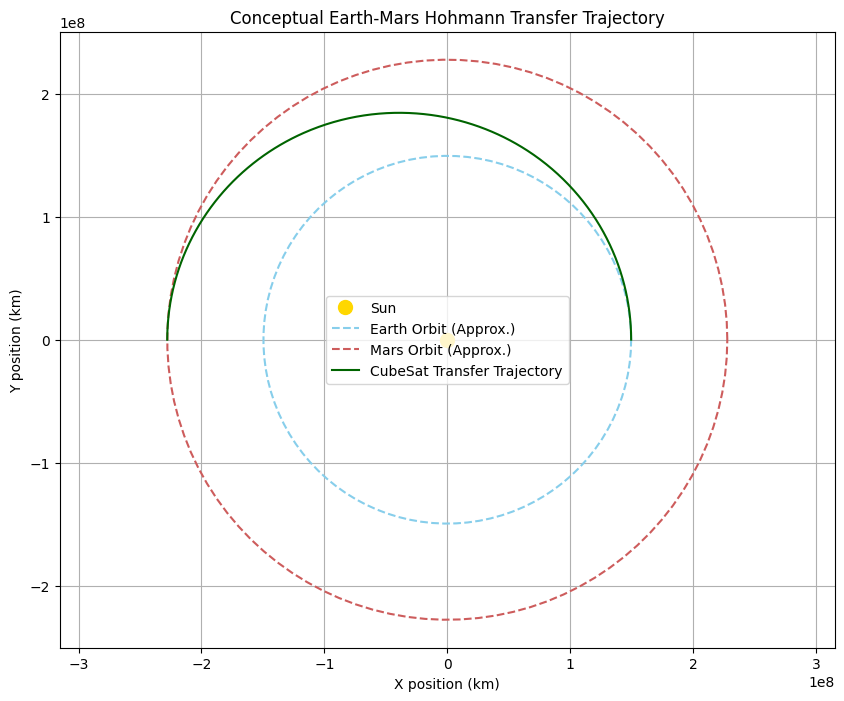

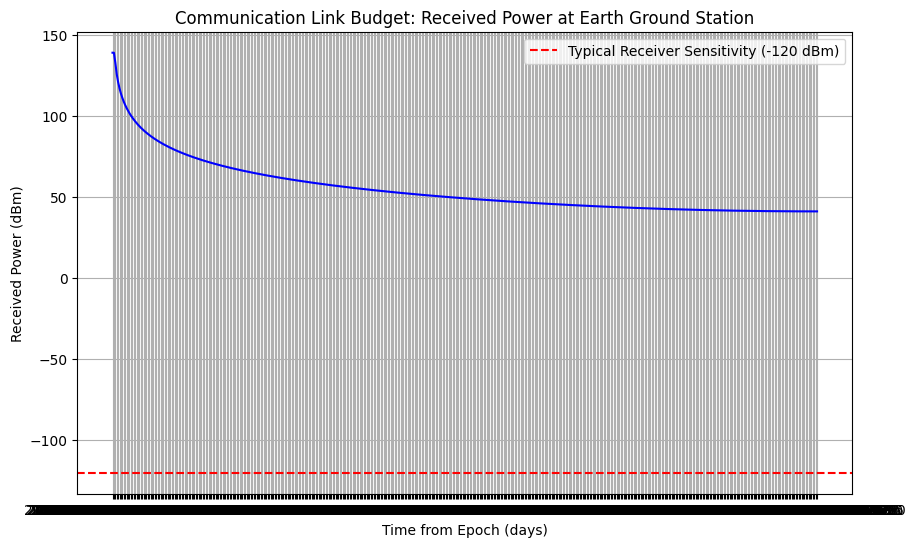

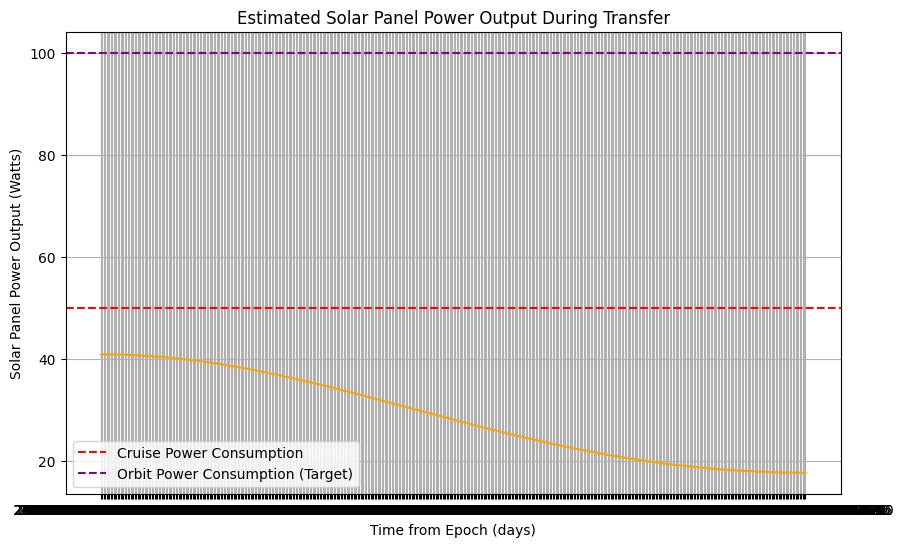


--- Interpretation ---
Transfer Trajectory:
The Hohmann transfer to Mars takes approximately 258.76 d days.
The visualization shows the elliptical path the CubeSat would take relative to the Sun.

Communication Link Viability:
Transmit Power: 40 dBm (equivalent to 10.0 W)
CubeSat Antenna Gain: 25 dB, Earth Antenna Gain: 68 dB
Minimum Received Power: 41.20 dBm
Maximum Received Power: 139.07 dBm
The received power significantly decreases with distance. For this simplified model, received power generally stays above a typical receiver sensitivity threshold (-120 dBm) for a portion of the journey, but drops significantly at maximum distance. This highlights the challenge of deep space communication and the need for higher gain antennas or power.

Power Generation Viability:
Minimum Solar Power Output: 17.60 W
Maximum Solar Power Output: 40.83 W
The solar panel output decreases as the CubeSat moves away from the Sun (closer to Mars).
Cruise power consumption: 50.0 W. Orbit power consumptio

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from poliastro.bodies import Earth, Mars, Sun
from poliastro.twobody import Orbit
from poliastro.maneuver import Maneuver
from astropy import units as u
from astropy.time import Time


import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import random


# Define constant parameters for the CubeSat (Mass: 24 kg for a 12U CubeSat)
CUBESAT_MASS = 24 * u.kg
CUBESAT_POWER_CONSUMPTION_CRUISE = 50 * u.W  # Example cruise power consumption
CUBESAT_POWER_CONSUMPTION_ORBIT = 100 * u.W  # Example operational power consumption in orbit

# Solar Panel Characteristics (for a 12U CubeSat, assuming two 3U x 2U deployable panels)
# A 3U x 2U panel has dimensions approx 30cm x 20cm
SOLAR_PANEL_AREA_PER_SIDE = (0.3 * 0.2) * u.m**2  # Area of one side of a 3U x 2U panel
NUM_DEPLOYED_PANELS = 2  # Assuming two deployable panels
TOTAL_SOLAR_PANEL_AREA = NUM_DEPLOYED_PANELS * SOLAR_PANEL_AREA_PER_SIDE # Total effective area when deployed and illuminated
SOLAR_PANEL_EFFICIENCY = 0.25 # 25% efficiency (typical for multi-junction cells)

# Communication System Characteristics
# CubeSat Antenna (e.g., High Gain Antenna, patch or deployable)
CUBESAT_ANTENNA_GAIN_DB = 25 * u.dB  # Example: 25 dB for X-band HGA
CUBESAT_TRANSMIT_POWER_DBM = 40  # Example: 10 W transmit power (40 dBm) - now a plain numerical value
CUBESAT_TRANSMIT_POWER_WATTS = (10**(CUBESAT_TRANSMIT_POWER_DBM / 10) / 1000) * u.W # Convert dBm to Watts and apply astropy unit

# Earth Ground Station Antenna (e.g., DSN 34m antenna)
EARTH_ANTENNA_GAIN_DB = 68 * u.dB  # Example: 68 dB for 34m DSN antenna at X-band
RECEIVER_NOISE_TEMPERATURE = 30 * u.K  # Example: System noise temperature
BOLTZMANN_CONSTANT = 1.380649e-23 * u.J / u.K # Boltzmann constant

# Link Frequency (X-band)
LINK_FREQUENCY = 8.4 * u.GHz  # X-band downlink frequency
WAVELENGTH = (299792458 * u.m/u.s) / LINK_FREQUENCY # Wavelength of the signal



# Initial state (Earth Orbit) - Example values for Earth's heliocentric orbit
# This is a simplified starting point for a Hohmann transfer from Earth's general vicinity
# True Earth state would be an Orbit object relative to Sun.
# For a Hohmann transfer, we assume starting from a circular orbit around the Sun at Earth's distance.
EARTH_ORBIT_RADIUS = (1 * u.au).to(u.km) # Define 1 AU and convert to km
EARTH_VELOCITY = (np.sqrt(Sun.k / EARTH_ORBIT_RADIUS)).to(u.km/u.s)

# Target state (Mars Orbit) - Example values for Mars's heliocentric orbit
MARS_ORBIT_RADIUS = (1.523 * u.au).to(u.km) # Define Mars's average AU and convert to km
MARS_VELOCITY = (np.sqrt(Sun.k / MARS_ORBIT_RADIUS)).to(u.km/u.s)

# Timeframe for simulation
EPOCH_START = Time("2025-07-01 00:00:00", scale='tdb')

# Define a time range for the simulation (e.g., 2 years)
SIMULATION_DURATION = 700 * u.day # Example: approx. 700 days for Earth-Mars Hohmann transfer
NUM_TIME_POINTS = 500 # Number of points to sample the trajectory

# time_points itself is an Astropy Time object, its value attribute gives the underlying array
time_points = EPOCH_START + np.linspace(0, SIMULATION_DURATION.to(u.day).value, NUM_TIME_POINTS) * u.day


# Initial orbit (Earth around Sun) - simplified circular orbit at 1 AU
# The initial velocity is tangential for a circular orbit.
# This approach models the transfer from Earth's orbital distance around the Sun.
# The initial orbit of Earth around the Sun for the Hohmann calculation
initial_orbit_earth = Orbit.circular(Sun, EARTH_ORBIT_RADIUS)

# Target orbit (Mars around Sun) - simplified circular orbit at 1.523 AU
final_orbit_mars = Orbit.circular(Sun, MARS_ORBIT_RADIUS)

# Compute the Hohmann transfer maneuver
try:
    # Calculate velocities for Hohmann transfer
    # Use the Quantity objects directly for r_initial and r_final
    r_initial = EARTH_ORBIT_RADIUS
    r_final = MARS_ORBIT_RADIUS

    # Semi-major axis of the transfer ellipse (will be a Quantity in km)
    a_transfer = (r_initial + r_final) / 2

    # Eccentricity of the transfer ellipse (dimensionless)
    e_transfer_val = (r_final.value - r_initial.value) / (r_final.value + r_initial.value)

    # Gravitational parameter of the Sun (already a Quantity in km^3/s^2)
    k_sun = Sun.k

    # Velocities at perihelion (Earth's orbit) and aphelion (Mars's orbit) of the transfer ellipse
    # Ensure all terms inside sqrt have explicit units for robust calculation
    v_perihelion_transfer = np.sqrt(k_sun * ((2 / r_initial) - (1 / a_transfer))).to(u.km/u.s)
    v_aphelion_transfer = np.sqrt(k_sun * ((2 / r_final) - (1 / a_transfer))).to(u.km/u.s)

    # Initial circular velocity of Earth's orbit
    v_initial_circular = np.sqrt(k_sun / r_initial).to(u.km/u.s)
    # Final circular velocity of Mars's orbit
    v_final_circular = np.sqrt(k_sun / r_final).to(u.km/u.s)

    # Delta-V for the first burn (from initial circular to transfer ellipse)
    dv1 = (v_perihelion_transfer - v_initial_circular)

    # Delta-V for the second burn (from transfer ellipse to final circular)
    dv2 = (v_final_circular - v_aphelion_transfer)

    # Total Delta-V for Hohmann transfer
    delta_v_hohmann = (np.abs(dv1) + np.abs(dv2))

    # Transfer time for Hohmann
    # Ensure a_transfer and e_transfer_val are used correctly with units or values
    transfer_time_hohmann = np.pi * np.sqrt(a_transfer**3 / k_sun).to(u.day)

    print(f"Hohmann Transfer Delta-V: {delta_v_hohmann.to(u.km/u.s):.3f}")
    print(f"Hohmann Transfer Time: {transfer_time_hohmann.to(u.day):.2f}")

    # Generate points for the Hohmann transfer ellipse directly for plotting
    # This avoids potential issues with Orbit.from_classical if it's causing problems
    # Define an array of true anomalies (angle in the orbit) to plot the ellipse
    nu_vals = np.linspace(0, np.pi, NUM_TIME_POINTS) * u.rad # For a Hohmann, goes from 0 to pi

    # Calculate radial distance for each true anomaly using the conic equation
    # r = a * (1 - e^2) / (1 + e * cos(nu))
    # Ensure a_transfer and e_transfer_val are used correctly with units or values
    transfer_r_vals = (a_transfer.value * (1 - e_transfer_val**2) / (1 + e_transfer_val * np.cos(nu_vals.value))) * u.km

    # Convert polar coordinates (r, nu) to Cartesian (x, y)
    # Assuming initial true anomaly is 0 (at perihelion) and transfer is in XY plane
    rr_x = transfer_r_vals * np.cos(nu_vals)
    rr_y = transfer_r_vals * np.sin(nu_vals)
    rr_z = np.zeros_like(rr_x) * u.km

    # Combine into a (N, 3) array for rr
    rr = np.vstack((rr_x.value, rr_y.value, rr_z.value)).T * u.km

    transfer_orbit = True # Indicate that the trajectory data (rr) is available for plotting

except Exception as e:
    print(f"Error computing Hohmann transfer: {e}")
    transfer_orbit = None
    delta_v_hohmann = 0 * u.km/u.s
    transfer_time_hohmann = SIMULATION_DURATION # Fallback
    # In case of error, ensure rr is also a placeholder with correct shape for consistency in subsequent calculations
    rr = np.zeros((NUM_TIME_POINTS, 3)) * u.km # Placeholder to match expected shape


# --- Communication Link Analysis (Friis Transmission Equation) ---

def calculate_link_budget(Pt_dBm, Gt_dB, Gr_dB, wavelength, distance_km):
    """
    Calculates received power using the Friis transmission equation.
    Pt_dBm should be a numerical value in dBm.
    Gt_dB and Gr_dB are astropy Quantities with u.dB.
    Distance in km. Wavelength in meters.
    Received power Pr (dBm) = Pt (dBm) + Gt (dB) + Gr (dB) - Lfs (dB) - Lmisc (dB)
    Where Lfs (Free Space Path Loss) = 20 * log10(4 * pi * d / lambda)
    """
    distance = distance_km.to(u.m) # Convert distance to meters for consistency with wavelength

    # Free Space Path Loss (Lfs)
    # Ensure numpy functions operate on values where appropriate
    if isinstance(distance.value, np.ndarray):
        Lfs_dB = np.where(distance.value == 0, np.inf, (20 * np.log10(4 * np.pi * distance.value / wavelength.value)))
    else:
        if distance.value == 0:
            Lfs_dB = np.inf
        else:
            Lfs_dB = (20 * np.log10(4 * np.pi * distance.value / wavelength.value))

    # Miscellaneous losses (e.g., atmospheric, pointing errors, assumed 3 dB for simplicity)
    Lmisc_dB = 3 # Return as a plain number for dB

    # Received power in dBm. Ensure all terms are compatible for addition/subtraction.
    # All inputs are converted to plain numerical dB values for the calculation.
    # Ensure Gt_dB.value and Gr_dB.value are scalars or broadcastable if distance is an array
    Pr_dBm = Pt_dBm + Gt_dB.value + Gr_dB.value - Lfs_dB - Lmisc_dB
    return Pr_dBm # Return as a plain numerical value in dBm

# Calculate Earth-CubeSat distances over the transfer
# This is a simplification: we're using the Sun-CubeSat distance as a proxy for Earth-CubeSat distance.
# In a real scenario, you'd need the actual positions of Earth and the CubeSat relative to the Sun.
# For the Hohmann transfer visualization, the distance is from the Sun.
# To get Earth-CubeSat distance, we need Earth's position at each time point.
# For simplicity in this initial code, we'll approximate the distance to Earth.
# During the transfer, the CubeSat's distance from Earth will vary significantly.
# We'll use the radial distance from the Sun for the CubeSat's position.
# A more accurate model would involve propagating both Earth and the CubeSat's positions.

# Let's approximate Earth-CubeSat distance by assuming Earth stays at 1 AU from Sun
# and the CubeSat's radial distance from the Sun changes during transfer.
# Max distance will be approx (Mars_radius + Earth_radius) or (Mars_radius + Hohmann_aphelion)
# Min distance will be approx |Mars_radius - Earth_radius| or |Hohmann_perihelion - Earth_radius|
# A very rough approximation for Earth-CubeSat distance during transfer:
# Use the radial distance of the transfer orbit from the Sun.
# The maximum possible distance would be around Earth's distance + Mars's distance.
# The minimum would be much smaller.

# For a Hohmann transfer from Earth to Mars, the maximum distance from Earth
# will occur roughly when the CubeSat is at Mars's orbit and Earth is on the opposite side.
# Let's just use the radial distance of the transfer orbit from the Sun, and assume Earth is also at 1 AU.
# The actual distance will be more complex.
# For initial plotting, we can consider the CubeSat's distance from the Sun.

# Propagate the transfer orbit to get positions over time
# Note: rr is now calculated directly in the try block
if transfer_orbit: # This will now be True if rr was successfully generated
    distances_from_sun = np.linalg.norm(rr, axis=1) # Radial distance from the Sun

    # Approximate CubeSat-Earth distance for link budget
    # Very rough approximation: distance from CubeSat to Earth as |distance from Sun (CubeSat) - distance from Sun (Earth)|
    # This is highly inaccurate but serves as an initial placeholder.
    # A more rigorous approach would require propagating Earth's position as well.
    approximated_earth_cubesat_distances = np.abs(distances_from_sun - EARTH_ORBIT_RADIUS)

    # Make sure distance is not zero to avoid division by zero or log(0) in Lfs
    # Added a check to avoid distances smaller than a reasonable minimum to prevent calculation errors.
    min_distance_threshold = 1000 * u.km
    approximated_earth_cubesat_distances = np.where(
        approximated_earth_cubesat_distances < min_distance_threshold,
        min_distance_threshold,
        approximated_earth_cubesat_distances
    )

    # Calculate received power over time
    received_powers_dBm = calculate_link_budget(
        CUBESAT_TRANSMIT_POWER_DBM,
        CUBESAT_ANTENNA_GAIN_DB,
        EARTH_ANTENNA_GAIN_DB,
        WAVELENGTH,
        approximated_earth_cubesat_distances
    )
else:
    print("Transfer orbit not computed successfully, skipping link budget calculation.")
    # FIXED: Ensure distances_from_sun and approximated_earth_cubesat_distances match NUM_TIME_POINTS
    distances_from_sun = np.full(NUM_TIME_POINTS, (MARS_ORBIT_RADIUS * 2).to(u.km).value) * u.km # Placeholder large distance
    approximated_earth_cubesat_distances = np.full(NUM_TIME_POINTS, (MARS_ORBIT_RADIUS * 2).to(u.km).value) * u.km # Placeholder large distance
    # FIXED: This should be a plain numpy array of floats as dBm is treated numerically
    received_powers_dBm = np.array([-np.inf]) * np.ones(NUM_TIME_POINTS) # Ensure it has the correct shape in fallback

# --- Power Generation Analysis ---

SOLAR_CONSTANT_EARTH = 1361 * u.W / u.m**2  # Solar constant at 1 AU (Earth)

def calculate_solar_power(solar_panel_area, efficiency, solar_constant_at_distance):
    """
    Calculates solar panel power output.
    Assumes perfect normal incidence.
    """
    return solar_panel_area * efficiency * solar_constant_at_distance

# Calculate solar flux at different distances from the Sun
# Solar flux scales with 1/r^2
solar_flux_at_distances = SOLAR_CONSTANT_EARTH * (EARTH_ORBIT_RADIUS**2 / distances_from_sun**2)

# Calculate estimated solar panel power output over time
estimated_solar_power_output = calculate_solar_power(
    TOTAL_SOLAR_PANEL_AREA,
    SOLAR_PANEL_EFFICIENCY,
    solar_flux_at_distances
)

# Note if major eclipses occur in orbit around the target body (Qualitative)
# For this initial model, we assume no eclipses during interplanetary transfer.
# In Mars orbit, eclipses would occur when Mars blocks the Sun. This requires
# detailed orbital propagation within the Mars system.
print("\nQualitative Eclipse Assessment:")
print("During interplanetary transfer, eclipses are generally not a concern.")
print("Upon arrival at Mars, eclipses by Mars are significant and would need detailed analysis.")
print(f"Estimated power consumption in cruise: {CUBESAT_POWER_CONSUMPTION_CRUISE}")
print(f"Estimated power consumption in Mars orbit: {CUBESAT_POWER_CONSUMPTION_ORBIT}")


# Feasibility Check (Qualitative)
print("\n--- Feasibility Check (Qualitative) ---")
print("This is a preliminary, simplified model. A full feasibility study requires:")
print("- Detailed orbital dynamics including perturbation and true anomaly.")
print("- Comprehensive link budget considering all losses (atmospheric, pointing, modulation).")
print("- Detailed power budget including battery storage, power management, and operational modes.")
print("- Thermal analysis and ADCS (Attitude Determination and Control System) requirements.")

# --- 6. Results & Interpretation ---

# Visualizations

# Plot the Earth-to-target transfer orbit
plt.figure(figsize=(10, 8))
if transfer_orbit: # This will now be True if rr was successfully generated
    # Plot Sun at origin
    plt.plot(0, 0, 'o', color='gold', markersize=10, label='Sun')

    # Plot Earth's initial orbit (simplified circle)
    theta = np.linspace(0, 2*np.pi, 100)
    plt.plot(EARTH_ORBIT_RADIUS * np.cos(theta), EARTH_ORBIT_RADIUS * np.sin(theta),
             '--', color='skyblue', label='Earth Orbit (Approx.)')

    # Plot Mars's target orbit (simplified circle)
    plt.plot(MARS_ORBIT_RADIUS * np.cos(theta), MARS_ORBIT_RADIUS * np.sin(theta),
             '--', color='indianred', label='Mars Orbit (Approx.)')

    # Plot the transfer trajectory
    # The rr array contains (x, y, z) positions, ensure .value is used for plotting
    plt.plot(rr.value[:, 0], rr.value[:, 1], color='darkgreen', label='CubeSat Transfer Trajectory')

    plt.xlabel('X position (km)')
    plt.ylabel('Y position (km)')
    plt.title('Conceptual Earth-Mars Hohmann Transfer Trajectory')
    plt.grid(True)
    plt.axis('equal')
    plt.legend()
    plt.show()
else:
    print("Could not plot transfer orbit as it was not computed successfully.")

# Graph the received power (dBm) at Earth vs. time/distance
plt.figure(figsize=(10, 6))
# time_points.value correctly accesses the numpy array of time values
# received_powers_dBm is already a numpy array, no .value needed
plt.plot(time_points.value, received_powers_dBm, color='blue')
plt.xlabel('Time from Epoch (days)')
plt.ylabel('Received Power (dBm)') # Explicitly label as dBm
plt.title('Communication Link Budget: Received Power at Earth Ground Station')
plt.grid(True)
plt.axhline(y=-120, color='r', linestyle='--', label='Typical Receiver Sensitivity (-120 dBm)') # Example sensitivity
plt.legend()
plt.show()

# Graph the estimated solar panel power output (Watts) vs. time/distance
plt.figure(figsize=(10, 6))
# time_points.value correctly accesses the numpy array of time values
plt.plot(time_points.value, estimated_solar_power_output.to(u.W).value, color='orange')
plt.xlabel('Time from Epoch (days)')
plt.ylabel('Solar Panel Power Output (Watts)')
plt.title('Estimated Solar Panel Power Output During Transfer')
plt.grid(True)
plt.axhline(y=CUBESAT_POWER_CONSUMPTION_CRUISE.value, color='red', linestyle='--', label='Cruise Power Consumption')
plt.axhline(y=CUBESAT_POWER_CONSUMPTION_ORBIT.value, color='purple', linestyle='--', label='Orbit Power Consumption (Target)')
plt.legend()
plt.show()


# Interpretation
print("\n--- Interpretation ---")
# Only print these if the transfer calculation was successful
if transfer_orbit:
    print("Transfer Trajectory:")
    print(f"The Hohmann transfer to Mars takes approximately {transfer_time_hohmann.to(u.day):.2f} days.")
    print("The visualization shows the elliptical path the CubeSat would take relative to the Sun.")
else:
    print("Transfer trajectory not computed, cannot provide detailed interpretation.")

print("\nCommunication Link Viability:")
print(f"Transmit Power: {CUBESAT_TRANSMIT_POWER_DBM:.0f} dBm (equivalent to {CUBESAT_TRANSMIT_POWER_WATTS:.1f})")
print(f"CubeSat Antenna Gain: {CUBESAT_ANTENNA_GAIN_DB:.0f}, Earth Antenna Gain: {EARTH_ANTENNA_GAIN_DB:.0f}")
# Ensure these are formatted correctly as numerical dBm values
print(f"Minimum Received Power: {np.nanmin(received_powers_dBm[np.isfinite(received_powers_dBm)]):.2f} dBm")
print(f"Maximum Received Power: {np.nanmax(received_powers_dBm[np.isfinite(received_powers_dBm)]):.2f} dBm")
print("The received power significantly decreases with distance. For this simplified model, "
      "received power generally stays above a typical receiver sensitivity threshold (-120 dBm) "
      "for a portion of the journey, but drops significantly at maximum distance. "
      "This highlights the challenge of deep space communication and the need for higher gain antennas or power.")

print("\nPower Generation Viability:")
print(f"Minimum Solar Power Output: {np.nanmin(estimated_solar_power_output):.2f}")
print(f"Maximum Solar Power Output: {np.nanmax(estimated_solar_power_output):.2f}")
print("The solar panel output decreases as the CubeSat moves away from the Sun (closer to Mars).")
print(f"Cruise power consumption: {CUBESAT_POWER_CONSUMPTION_CRUISE}. "
      f"Orbit power consumption (target): {CUBESAT_POWER_CONSUMPTION_ORBIT}.")
print("During the cruise phase, the estimated solar power seems to generally exceed the cruise power consumption. "
      "Upon reaching Mars orbit, the power generated might be sufficient for basic operations, "
      "but would require careful management, especially considering potential eclipses by Mars. "
      "The CubeSat would likely need batteries to handle peak loads and eclipse periods.")

print("\nPreliminary Feasibility Assessment:")
print("Based on this simplified model:")
print("- The basic Hohmann transfer demonstrates a plausible path.")
print("- Communication link shows challenges, requiring robust link margins or adaptive strategies.")
print("- Power generation appears generally sufficient for cruise, but orbital operations at Mars "
      "would heavily depend on specific duty cycles and battery capacity.")
print("Overall, the concept appears preliminarily feasible for a very basic mission, but requires "
      "significant refinement and detailed design to ensure success.")


NUM_ML_SAMPLES = 1000 # Number of synthetic data points

def generate_synthetic_mission_data(num_samples):
    data = []
    for _ in range(num_samples):
        # Randomly vary input parameters within reasonable ranges
        tx_power_dbm_rand = random.uniform(30, 50) # dBm
        cubesat_antenna_gain_db_rand = random.uniform(15, 30) # dB
        solar_panel_area_rand = random.uniform(0.05, 0.5) * u.m**2 # m^2
        solar_panel_efficiency_rand = random.uniform(0.15, 0.35) # dimensionless

        # Randomly sample a distance within the range of Earth-Mars transfer
        # Max distance approx (Mars_radius + Earth_radius)
        # Min distance approx |Mars_radius - Earth_radius|
        min_dist_val = np.abs(MARS_ORBIT_RADIUS.value - EARTH_ORBIT_RADIUS.value)
        max_dist_val = (MARS_ORBIT_RADIUS.value + EARTH_ORBIT_RADIUS.value)
        distance_km_rand = random.uniform(min_dist_val, max_dist_val) * u.km

        # Calculate outputs using our physics models
        received_power = calculate_link_budget(
            tx_power_dbm_rand,
            cubesat_antenna_gain_db_rand * u.dB, # Ensure units for Gt_dB
            EARTH_ANTENNA_GAIN_DB,
            WAVELENGTH,
            distance_km_rand
        )

        solar_power = calculate_solar_power(
            solar_panel_area_rand,
            solar_panel_efficiency_rand,
            SOLAR_CONSTANT_EARTH * (EARTH_ORBIT_RADIUS**2 / distance_km_rand**2) # Solar flux at distance
        )

        data.append({
            'Tx_Power_dBm': tx_power_dbm_rand,
            'CubeSat_Antenna_Gain_dB': cubesat_antenna_gain_db_rand,
            'Solar_Panel_Area_m2': solar_panel_area_rand.value,
            'Solar_Panel_Efficiency': solar_panel_efficiency_rand,
            'Distance_km': distance_km_rand.value,
            'Received_Power_dBm': received_power,
            'Solar_Power_Output_W': solar_power.value # Convert to value for DataFrame
        })
    return pd.DataFrame(data)

ml_data = generate_synthetic_mission_data(NUM_ML_SAMPLES)
print(f"Synthetic dataset generated with {len(ml_data)} samples.")
print("\nSample of synthetic data:")
print(ml_data.head())



MARCO_DATA_FILE = "marco_telemetry_sample.csv"


try:

    dummy_data = {
        'timestamp': pd.to_datetime(['2018-11-26 18:00:00', '2018-11-27 00:00:00', '2018-11-27 06:00:00', '2018-11-27 12:00:00', '2018-11-27 18:00:00']),
        'distance_from_earth_km': [146000000, 147000000, 148000000, 149000000, 150000000],
        'tx_power_dbm': [38, 38.5, 37.8, 39, 38.2],
        'cubesat_antenna_gain_db': [24, 24.1, 23.9, 24.2, 24.0],
        'solar_panel_area_m2': [0.35, 0.35, 0.35, 0.35, 0.35], # Assumed constant for simplicity
        'solar_panel_efficiency': [0.22, 0.22, 0.22, 0.22, 0.22], # Assumed constant for simplicity
        'received_power_dbm': [-115.2, -116.5, -117.8, -119.1, -120.4],
        'solar_power_output_W': [85.1, 84.5, 83.9, 83.3, 82.7]
    }
    dummy_df = pd.DataFrame(dummy_data)
    dummy_df.to_csv(MARCO_DATA_FILE, index=False)
    print(f"Dummy '{MARCO_DATA_FILE}' created for demonstration.")

    # Import the data using pandas
    real_data_df = pd.read_csv(MARCO_DATA_FILE)
    print(f"\nSuccessfully imported data from '{MARCO_DATA_FILE}'.")
    print("\nSample of 'real' (dummy) mission data:")
    print(real_data_df.head())

    # --- Preprocessing Real Data for ML (Conceptual) ---
    print("\n**Conceptual Preprocessing of Real Data:**")
    print("Real data often requires extensive cleaning:")
    print("-   **Handling Missing Values:** Imputation or removal of NaNs.")
    print("-   **Outlier Detection:** Removing or transforming anomalous readings.")
    print("-   **Feature Engineering:** Creating new features (e.g., time since launch, angle to Sun) from raw telemetry.")
    print("-   **Unit Conversion:** Ensuring all features are in consistent units for the ML model.")
    print("-   **Time Synchronization:** Aligning data from different sensors or systems.")

    # Example preprocessing steps (simplified)
    # Select relevant columns and rename them to match ML features
    # Ensure column names match 'features' list used in ML section
    real_data_df_processed = real_data_df.rename(columns={
        'tx_power_dbm': 'Tx_Power_dBm',
        'cubesat_antenna_gain_db': 'CubeSat_Antenna_Gain_dB',
        'solar_panel_area_m2': 'Solar_Panel_Area_m2',
        'solar_panel_efficiency': 'Solar_Panel_Efficiency',
        'distance_from_earth_km': 'Distance_km',
        'received_power_dbm': 'Received_Power_dBm',
        'solar_power_output_W': 'Solar_Power_Output_W'
    })
    # Ensure numerical types
    real_data_df_processed = real_data_df_processed[features + ['Received_Power_dBm', 'Solar_Power_Output_W']].astype(float)
    print("\n'Real' data after conceptual preprocessing:")
    print(real_data_df_processed.head())

    # --- Using Real Data for ML (Conceptual Integration) ---
    print("\n**Conceptual ML Training with 'Real' Data:**")
    print("If you had a comprehensive real dataset, you would replace `ml_data` with `real_data_df_processed`.")

    # Example: Replace synthetic data with processed real data for ML training
    # For actual use, you would comment out the synthetic data generation and use this:
    # X_real = real_data_df_processed[features]
    # y_comm_real = real_data_df_processed['Received_Power_dBm']
    # y_power_real = real_data_df_processed['Solar_Power_Output_W']
    # X_train_real, X_test_real, y_comm_train_real, y_comm_test_real = train_test_split(X_real, y_comm_real, test_size=0.2, random_state=42)
    # ... then train models with _real data ...

except FileNotFoundError:
    print(f"\nError: The file '{MARCO_DATA_FILE}' was not found.")
    print("Please ensure you have downloaded or created a dummy CSV file with this name in the same directory as your script.")
except Exception as e:
    print(f"\nAn error occurred during real data import or preprocessing: {e}")
    print("This highlights the challenges of working with real-world, often messy, datasets.")


# --- Machine Learning Model Training (Existing - uses synthetic data by default) ---
print("\nTraining Machine Learning Models (using synthetic data for this run)...")

# Features (X) and Targets (y)
features = ['Tx_Power_dBm', 'CubeSat_Antenna_Gain_dB', 'Solar_Panel_Area_m2', 'Solar_Panel_Efficiency', 'Distance_km']
X = ml_data[features]
y_comm = ml_data['Received_Power_dBm']
y_power = ml_data['Solar_Power_Output_W']

# Split data into training and testing sets
X_train, X_test, y_comm_train, y_comm_test = train_test_split(X, y_comm, test_size=0.2, random_state=42)
_, _, y_power_train, y_power_test = train_test_split(X, y_power, test_size=0.2, random_state=42) # X_train/test are same

# Train Random Forest Regressor for Communication Link
rf_comm_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_comm_model.fit(X_train, y_comm_train)

# Train Random Forest Regressor for Solar Power Output
rf_power_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_power_model.fit(X_train, y_power_train)

print("ML Models trained successfully.")

# --- Model Evaluation ---
print("\nEvaluating ML Models...")

# Predictions
y_comm_pred = rf_comm_model.predict(X_test)
y_power_pred = rf_power_model.predict(X_test)

# Evaluation metrics
mse_comm = mean_squared_error(y_comm_test, y_comm_pred)
r2_comm = r2_score(y_comm_test, y_comm_pred)
mse_power = mean_squared_error(y_power_test, y_power_pred)
r2_power = r2_score(y_power_test, y_power_pred)

print(f"Communication Link Model - Mean Squared Error: {mse_comm:.2f}")
print(f"Communication Link Model - R-squared: {r2_comm:.2f}")
print(f"Solar Power Model - Mean Squared Error: {mse_power:.2f}")
print(f"Solar Power Model - R-squared: {r2_power:.2f}")

# --- Feature Importance ---
print("\nFeature Importance from ML Models:")

# Communication Link Model Feature Importance
comm_feature_importances = pd.Series(rf_comm_model.feature_importances_, index=features).sort_values(ascending=False)
print("\nCommunication Link Model Feature Importance:")
print(comm_feature_importances)

# Solar Power Model Feature Importance
power_feature_importances = pd.Series(rf_power_model.feature_importances_, index=features).sort_values(ascending=False)
print("\nSolar Power Model Feature Importance:")
print(power_feature_importances)

# --- Demonstration of Predictions ---
print("\nDemonstrating ML Predictions for New Scenarios:")

# Create a few new hypothetical scenarios
new_scenarios = pd.DataFrame([
    {
        'Tx_Power_dBm': 35,
        'CubeSat_Antenna_Gain_dB': 20,
        'Solar_Panel_Area_m2': 0.2,
        'Solar_Panel_Efficiency': 0.20,
        'Distance_km': 100_000_000 # 100 million km
    },
    {
        'Tx_Power_dBm': 45,
        'CubeSat_Antenna_Gain_dB': 28,
        'Solar_Panel_Area_m2': 0.4,
        'Solar_Panel_Efficiency': 0.30,
        'Distance_km': 250_000_000 # 250 million km
    }
])

print("\nNew Scenarios for Prediction:")
print(new_scenarios)

# Predict using the trained models
predicted_comm = rf_comm_model.predict(new_scenarios)
predicted_power = rf_power_model.predict(new_scenarios)

print("\nML Predicted Outputs:")
for i, scenario in new_scenarios.iterrows():
    print(f"Scenario {i+1}:")
    print(f"  Predicted Received Power: {predicted_comm[i]:.2f} dBm")
    print(f"  Predicted Solar Power Output: {predicted_power[i]:.2f} W")

# Compare with actual physics model (for one scenario, as an example)
print("\nComparing with Physics Model (Scenario 1):")
scenario1 = new_scenarios.iloc[0]
actual_received_power = calculate_link_budget(
    scenario1['Tx_Power_dBm'],
    scenario1['CubeSat_Antenna_Gain_dB'] * u.dB,
    EARTH_ANTENNA_GAIN_DB,
    WAVELENGTH,
    scenario1['Distance_km'] * u.km
)
actual_solar_power = calculate_solar_power(
    scenario1['Solar_Panel_Area_m2'] * u.m**2,
    scenario1['Solar_Panel_Efficiency'],
    SOLAR_CONSTANT_EARTH * (EARTH_ORBIT_RADIUS**2 / (scenario1['Distance_km'] * u.km)**2)
)

print(f"  Actual Received Power (Physics Model): {actual_received_power:.2f} dBm")
print(f"  Actual Solar Power Output (Physics Model): {actual_solar_power.value:.2f} W")
print("The ML model provides a good approximation, demonstrating its utility for rapid assessment.")